In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Create simplified model
p = RollRig.base_params(3)  
sm = mf.SymbolicModel.from_file('RollRigModel.py')


In [3]:
sm.M

⎡                                                                             
⎢                    2         2           2                                  
⎢2⋅I_xxf + I_xxw + η₀ ⋅m_w + η₁ ⋅m_w + 2⋅η₂ ⋅m_f - η₂⋅m_f⋅s⋅σ⋅cos(q₁) - η₂⋅m_f
⎢                                                                             
⎢                                                                             
⎢                                                              2       η₂⋅m_f⋅
⎢                                                   -I_xxf - η₂ ⋅m_f + ───────
⎢                                                                             
⎢                                                                             
⎢                                                              2       η₂⋅m_f⋅
⎢                                                    I_xxf + η₂ ⋅m_f - ───────
⎣                                                                             

                                                   

In [4]:
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0,p.alpha_1.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[1])),
             p.alpha_2.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[2]))})
sm.to_file('tempModel_free.py')

In [26]:
# Add fixed params to dict
params = {}
params['c'] = 0.067
params['s'] = 1
params['sigma'] = 0.272
params['alpha_r'] = 0
params['c_d_max'] = 1
params['a_0'] = 2*np.pi
params['a_1'] = 2*np.pi
params['m_w'] = 0.773
params['I_xx_w'] = 0.019480411
params['eta_0'] = 0.00198
params['eta_1'] = -0.00273
params['c_d_max'] = 0

In [31]:
# create configs
configs = []
tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(10)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['eta_2'] = 0.0766*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.85e-5
tmp_params['m_f'] = 0.031
configs.append(({'Mode':'Free'},tmp_params.copy()))

tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(20)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['eta_2'] = 0.0786*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.55e-5
tmp_params['m_f'] = 0.0485
configs.append(({'Mode':'Free'},tmp_params.copy()))

tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(30)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['eta_2'] = 0.0766*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.68e-5
tmp_params['m_f'] = 0.05
configs.append(({'Mode':'Free'},tmp_params.copy()))

In [32]:
# create Jobs
attitudes=[]
vs = [15,20,25,30]
for v in vs:
    aas = [7,14,21]
    offset = [-0.13,-0.10,0.05]
    for i,tm in enumerate([1.57,2.31,2.75]):
        beta = (tm)*8.4e-4*v**2+offset[i]
        attitudes.append(({"AileronAngle":aas[i],},{"V":v,"beta":beta}))

In [33]:
jobs=[({**config,**att},{**params,**config_params,**att_params}) for config,config_params in configs for att,att_params in attitudes]
jobs[0]

({'Mode': 'Free', 'AileronAngle': 7},
 {'c': 0.067,
  's': 1,
  'sigma': 0.272,
  'alpha_r': 0,
  'c_d_max': 0,
  'a_0': 6.283185307179586,
  'a_1': 6.283185307179586,
  'm_w': 0.773,
  'I_xx_w': 0.019480411,
  'eta_0': 0.00198,
  'eta_1': -0.00273,
  'Lambda': 0.17453292519943295,
  'alpha_c': 0.0,
  'eta_2': 0.07543627388073514,
  'I_xx_f': 8.85e-05,
  'm_f': 0.031,
  'V': 15,
  'beta': 0.16673000000000004})

139.9788663750493


{'Mode': 'Free',
 'AileronAngle': 14,
 'c': 0.067,
 's': 1,
 'sigma': 0.272,
 'alpha_r': 0,
 'c_d_max': 0,
 'a_0': 6.283185307179586,
 'a_1': 6.283185307179586,
 'm_w': 0.773,
 'I_xx_w': 0.019480411,
 'eta_0': 0.00198,
 'eta_1': -0.00273,
 'Lambda': 0.17453292519943295,
 'alpha_c': 0.0,
 'eta_2': 0.07543627388073514,
 'I_xx_f': 8.85e-05,
 'm_f': 0.031,
 'V': 15,
 'beta': 0.33659000000000006}

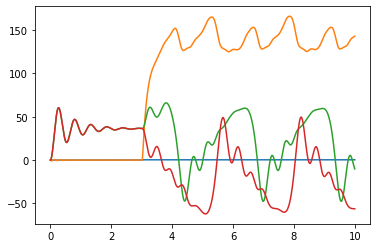

In [34]:
j_i = 1
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']
#GenRunData('tempModel.py',3,[0]*p.qs*2,10,{**params,**jobs[0]},names,{'Mode':'Free'},100)[100]
data = RollRig.GenRunData_StepTorque('tempModel_free.py',3,[0]*6,10,jobs[j_i][1],names,{**jobs[j_i][0]},100)
df = pd.DataFrame(data)
plt.plot(df['t'],df['torque'])
plt.plot(df['t'],np.rad2deg(df['Roll Rate']))
plt.plot(df['t'],np.rad2deg(df['Left FWT Angle']))
plt.plot(df['t'],np.rad2deg(df['Right FWT Angle']))


print(np.rad2deg(df[df['t']>4]['Roll Rate'].mean()))
{**jobs[j_i][0],**jobs[j_i][1]}

In [35]:
%%time
# for each job edit the parameters and pool it 
pool = mp.Pool(mp.cpu_count())
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']

res=[]
for job in jobs:
    res.append(pool.apply_async(RollRig.GenRunData_StepTorque, args = ('tempModel_free.py',3,[0]*6,15,job[1],names,job[0],100)))
pool.close()
pool.join()

ls = []
for i in res:
    ls += i.get()
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 1.03 s, sys: 269 ms, total: 1.3 s
Wall time: 39.1 s


In [36]:
df['Roll Rate [Deg]']=np.rad2deg(df['Roll Rate'])
df[df['t']>4].groupby(['Lambda','V','AileronAngle'])['Roll Rate [Deg]'].mean()

Lambda    V   AileronAngle
0.174533  15  7                72.534116
              14              140.263211
              21              221.635060
          20  7               128.049352
              14              210.933945
              21              289.264643
          25  7               183.320767
              14              278.948826
              21              358.606275
          30  7               233.121827
              14              344.001185
              21              427.605241
0.349066  15  7                64.579178
              14              139.013837
              21              227.072840
          20  7               129.564998
              14              213.495631
              21              291.807949
          25  7               182.715427
              14              282.157206
              21              357.074110
          30  7               228.337334
              14              337.428622
              21              

In [37]:
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparison/FreeData.csv', index = False)